# Imports

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Preprocess & Split Data

In [25]:
df = pd.read_excel("/content/new_relabelled_dataset_0NA.xlsx")
df.head()

,Unnamed: 0,Original_Text,Cleaned_Text,Score,Created_At,Hour_of_Day,Night_Post,Word_Count,Word_Length_Category,Subjectivity,Negative_Score,Neutral_Score,Positive_Score,Suicide_Risk
0,0,I Don't Want To Live Anymore I don't want to b...,dont want live anymore dont want alive family ...,1,2025-05-31 05:56:08,5,1,41,Very Long,0.342857,0.914468,0.074961,0.010571,High Risk
1,1,"Lifes a bitch I keep thinking of suicide, the ...",lifes bitch keep thinking suicide methods coul...,1,2025-05-31 06:01:58,6,0,81,Very Long,0.595754,0.604587,0.298809,0.096604,Moderate Risk
2,2,Why should anyone care if I'm not here? It's o...,anyone care im one less person worry insert ce...,1,2025-05-31 06:20:52,6,0,41,Very Long,0.352381,0.571609,0.379095,0.049296,Low Risk
3,3,"Before I end my life, I'm looking for someone ...",end life im looking someone adopt dog hi im vi...,1,2025-05-31 06:52:54,6,0,84,Very Long,0.528788,0.843974,0.145270,0.010756,High Risk
4,4,I can't stop having ideations about salt poiso...,cant stop ideations salt poisoning cant stop t...,1,2025-05-31 11:46:36,11,0,36,Very Long,0.750000,0.065900,0.280841,0.653260,Moderate Risk


In [26]:
df.isna().sum()

,0
Unnamed: 0,0
Original_Text,0
Cleaned_Text,0
Score,0
Created_At,0
Hour_of_Day,0
Night_Post,0
Word_Count,0
Word_Length_Category,0
Subjectivity,0


In [27]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,Original_Text,Cleaned_Text,Score,Created_At,Hour_of_Day,Night_Post,Word_Count,Word_Length_Category,Subjectivity,Negative_Score,Neutral_Score,Positive_Score,Suicide_Risk
0,I Don't Want To Live Anymore I don't want to b...,dont want live anymore dont want alive family ...,1,2025-05-31 05:56:08,5,1,41,Very Long,0.342857,0.914468,0.074961,0.010571,High Risk
1,"Lifes a bitch I keep thinking of suicide, the ...",lifes bitch keep thinking suicide methods coul...,1,2025-05-31 06:01:58,6,0,81,Very Long,0.595754,0.604587,0.298809,0.096604,Moderate Risk
2,Why should anyone care if I'm not here? It's o...,anyone care im one less person worry insert ce...,1,2025-05-31 06:20:52,6,0,41,Very Long,0.352381,0.571609,0.379095,0.049296,Low Risk
3,"Before I end my life, I'm looking for someone ...",end life im looking someone adopt dog hi im vi...,1,2025-05-31 06:52:54,6,0,84,Very Long,0.528788,0.843974,0.145270,0.010756,High Risk
4,I can't stop having ideations about salt poiso...,cant stop ideations salt poisoning cant stop t...,1,2025-05-31 11:46:36,11,0,36,Very Long,0.750000,0.065900,0.280841,0.653260,Moderate Risk


In [28]:
df.shape

(38288, 13)

## Check Data Balance

In [29]:
total = len(df)

print(f"Minimal risk: {len(df[df['Suicide_Risk'] == 'Minimal Concern'])} ({(len(df[df['Suicide_Risk'] == 'Minimal Concern']) / total) * 100:.2f}%)")
print(f"Low risk: {len(df[df['Suicide_Risk'] == 'Low Risk'])} ({(len(df[df['Suicide_Risk'] == 'Low Risk']) / total) * 100:.2f}%)")
print(f"Moderate risk: {len(df[df['Suicide_Risk'] == 'Moderate Risk'])} ({(len(df[df['Suicide_Risk'] == 'Moderate Risk']) / total) * 100:.2f}%)")
print(f"High risk: {len(df[df['Suicide_Risk'] == 'High Risk'])} ({(len(df[df['Suicide_Risk'] == 'High Risk']) / total) * 100:.2f}%)")

Minimal risk: 9541 (24.92%)
Low risk: 10999 (28.73%)
Moderate risk: 4597 (12.01%)
High risk: 13151 (34.35%)


## Balancing Data

In [30]:
# Oversampling
# Group data by risk categories
df_minimal = df[df['Suicide_Risk'] == 'Minimal Concern']
df_low = df[df['Suicide_Risk'] == 'Low Risk']
df_moderate = df[df['Suicide_Risk'] == 'Moderate Risk']
df_high = df[df['Suicide_Risk'] == 'High Risk']

# Find the size of the largest class
max_count = max(len(df_minimal), len(df_low), len(df_moderate), len(df_high))

# Oversample each class to match the largest class
df_minimal_up = resample(df_minimal, replace=True, n_samples=max_count, random_state=42)
df_low_up = resample(df_low, replace=True, n_samples=max_count, random_state=42)
df_moderate_up = resample(df_moderate, replace=True, n_samples=max_count, random_state=42)
df_high_up = resample(df_high, replace=True, n_samples=max_count, random_state=42)

# Combine the balanced DataFrame
df_balanced = pd.concat([df_minimal_up, df_low_up, df_moderate_up, df_high_up])

# Optional: Shuffle the resulting DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Show new class distribution
print(df_balanced['Suicide_Risk'].value_counts())

Suicide_Risk
Minimal Concern    13151
High Risk          13151
Moderate Risk      13151
Low Risk           13151
Name: count, dtype: int64


In [31]:
df_balanced

,Original_Text,Cleaned_Text,Score,Created_At,Hour_of_Day,Night_Post,Word_Count,Word_Length_Category,Subjectivity,Negative_Score,Neutral_Score,Positive_Score,Suicide_Risk
0,Whether it’s illegal or not it is still wrong!...,whether illegal still wrong people knew speaki...,37,2021-04-16 17:09:03,17,0,70,Very Long,0.580593,0.056538,0.211428,0.732034,Minimal Concern
1,"God wants me to kill myself I know it, I know ...",god wants kill know know know posted months ag...,1,2025-05-29 05:54:12,5,1,151,Very Long,0.541071,0.946665,0.049778,0.003557,High Risk
2,"Do you want to talk about it, I'm so sorry for...",want talk im sorry happened,95,2019-12-09 21:48:38,21,0,5,Normal,1.000000,0.627830,0.330160,0.042010,Moderate Risk
3,This is so true. Just like a slow rot of life,true like slow rot life,1,2020-04-28 21:32:12,21,0,5,Normal,0.525000,0.610957,0.355165,0.033878,Moderate Risk
4,Fuuuuuuuuck this is too real... I can't help b...,fuuuuuuuuck real cant help feel like parents n...,17,2024-03-23 11:49:30,11,0,23,Normal,0.216667,0.918245,0.074702,0.007054,High Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52599,Have faith that Corona-Chan will help us all.,faith coronachan help us,1,2020-03-07 16:34:44,16,0,4,Normal,0.000000,0.038468,0.735585,0.225947,Minimal Concern
52600,War's scary. Dunno if I wanna be around but I'...,wars scary dunno wanna around ive gotta protec...,10,2025-05-09 11:09:23,11,0,41,Very Long,0.580159,0.953198,0.044392,0.002410,High Risk
52601,need help w bf asap hey guys my boyfriend has ...,need help w bf asap hey guys boyfriend making ...,2,2025-05-31 07:00:44,7,0,52,Very Long,0.696712,0.600129,0.358461,0.041410,Moderate Risk
52602,Would you like to talk about it?,would like talk,0,2021-10-27 00:46:07,0,1,3,Very Short,0.000000,0.024053,0.753486,0.222462,Minimal Concern


## Encode Data

In [32]:
# Encode target labels
label_encoder = LabelEncoder()
df_balanced['Suicide_Risk_Label'] = label_encoder.fit_transform(df_balanced['Suicide_Risk'])
df_balanced.head()

,Original_Text,Cleaned_Text,Score,Created_At,Hour_of_Day,Night_Post,Word_Count,Word_Length_Category,Subjectivity,Negative_Score,Neutral_Score,Positive_Score,Suicide_Risk,Suicide_Risk_Label
0,Whether it’s illegal or not it is still wrong!...,whether illegal still wrong people knew speaki...,37,2021-04-16 17:09:03,17,0,70,Very Long,0.580593,0.056538,0.211428,0.732034,Minimal Concern,2
1,"God wants me to kill myself I know it, I know ...",god wants kill know know know posted months ag...,1,2025-05-29 05:54:12,5,1,151,Very Long,0.541071,0.946665,0.049778,0.003557,High Risk,0
2,"Do you want to talk about it, I'm so sorry for...",want talk im sorry happened,95,2019-12-09 21:48:38,21,0,5,Normal,1.000000,0.627830,0.330160,0.042010,Moderate Risk,3
3,This is so true. Just like a slow rot of life,true like slow rot life,1,2020-04-28 21:32:12,21,0,5,Normal,0.525000,0.610957,0.355165,0.033878,Moderate Risk,3
4,Fuuuuuuuuck this is too real... I can't help b...,fuuuuuuuuck real cant help feel like parents n...,17,2024-03-23 11:49:30,11,0,23,Normal,0.216667,0.918245,0.074702,0.007054,High Risk,0


## Vectorize Data

In [33]:
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df_balanced['Cleaned_Text'])

## Split Data

In [78]:
numeric_cols = [
    'Score', 'Hour_of_Day', 'Night_Post', 'Word_Count',
    'Subjectivity', 'Negative_Score', 'Neutral_Score', 'Positive_Score'
]

X_numeric = df_balanced[numeric_cols]
X_combined = hstack([X_text, X_numeric])
y = df_balanced['Suicide_Risk_Label']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Build XGBoost Model

In [80]:
Xmodel = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

Xmodel.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

# XGBoost Results

In [81]:
y_pred = Xmodel.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
                 precision    recall  f1-score   support

      High Risk       0.97      0.96      0.96      2622
       Low Risk       0.95      0.90      0.92      2654
Minimal Concern       0.96      0.97      0.96      2625
  Moderate Risk       0.90      0.96      0.93      2620

       accuracy                           0.95     10521
      macro avg       0.95      0.95      0.95     10521
   weighted avg       0.95      0.95      0.95     10521



In [82]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Confusion Matrix:
[[2506   61   13   42]
 [  57 2389   37  171]
 [   2   11 2536   76]
 [   8   54   46 2512]]


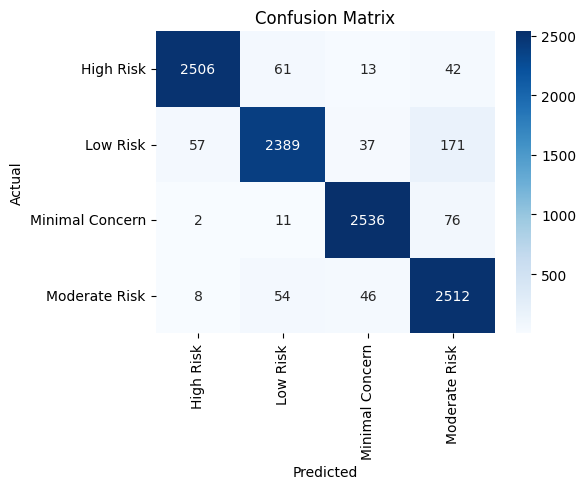

In [83]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [84]:
from sklearn.metrics import accuracy_score

train_preds = Xmodel.predict(X_train)
val_preds = Xmodel.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_test, val_preds)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Training Accuracy: 0.9731
Validation Accuracy: 0.9451


In [85]:
Xmodel.save_model("xgb_model.json")

## Testing XGBoost on NEW Posts

In [86]:
df_test = pd.read_excel("/content/test_dataset_labelled.xlsx")
df_test = df_test.drop(columns=["Unnamed: 0.1","Unnamed: 0"])
df_test

,Original_Text,Cleaned_Text,Score,Created_At,Hour_of_Day,Night_Post,Word_Count,Word_Length_Category,Subjectivity,Negative_Score,Neutral_Score,Positive_Score,Suicide_Risk
0,Jumping off thelwall viaduct. I drive over thi...,jumping thelwall viaduct drive bridge days one...,2,2025-06-01 18:08:30,18,0,17,Normal,0.000000,0.426053,0.488661,0.085285,Low Risk
1,i am going to kill myself on the 1st of july i...,going kill 1st july 18 years old live australi...,13,2025-06-01 17:49:38,17,0,117,Very Long,0.476000,0.929484,0.064471,0.006045,High Risk
2,Give me a reason Just any reason for me not to...,give reason reason set alarm 3 get wasted stea...,2,2025-06-01 17:30:20,17,0,17,Normal,0.350000,0.890801,0.101857,0.007341,High Risk
3,I think I'm gonna start smoking I never though...,think im gonna start smoking never thought wou...,1,2025-06-01 17:19:55,17,0,13,Normal,0.000000,0.805254,0.180914,0.013832,High Risk
4,Suicide sounds peaceful Like there is so reper...,suicide sounds peaceful like repercussions one...,4,2025-06-01 15:42:22,15,0,7,Normal,0.500000,0.475626,0.441238,0.083135,Moderate Risk
5,Why not end it all I'm so tired. What is there...,end im tired even live like honestly,1,2025-06-01 15:40:32,15,0,7,Normal,0.700000,0.936008,0.056430,0.007562,High Risk
6,Suicide actually sounds so good man Can u tell...,suicide actually sounds good man u tell ways 1...,1,2025-06-01 15:39:55,15,0,15,Normal,0.350000,0.454720,0.397819,0.147462,Low Risk
7,Your favorite non positivity positive subs? :-...,favorite non positivity positive subs freepost...,29,2025-05-23 13:54:34,13,0,29,Normal,0.516017,0.005714,0.201266,0.793020,Minimal Concern
8,Are there any other wholesome subs like this o...,wholesome subs like one id like unsubscribe th...,121,2025-05-11 14:55:46,14,0,20,Normal,0.716667,0.013427,0.177094,0.809479,Moderate Risk
9,The day spent well. Idk I'm happy today. I fel...,day spent well idk im happy today felt happy s...,58,2025-05-08 18:23:08,18,0,77,Very Long,0.601367,0.005631,0.035957,0.958412,Moderate Risk


In [87]:
X_numeric_test = df_test[numeric_cols]
X_tfidf_test = tfidf.transform(df_test['Cleaned_Text'])
X_combined_test = hstack([X_tfidf_test, X_numeric_test])

# Predict
y_pred_test = Xmodel.predict(X_combined_test)

# Map predictions back to original labels
df_test['Predicted_Label'] = label_encoder.inverse_transform(y_pred_test)

# View results
df_test[['Original_Text','Suicide_Risk', 'Predicted_Label']]


,Original_Text,Suicide_Risk,Predicted_Label
0,Jumping off thelwall viaduct. I drive over thi...,Low Risk,Low Risk
1,i am going to kill myself on the 1st of july i...,High Risk,High Risk
2,Give me a reason Just any reason for me not to...,High Risk,Low Risk
3,I think I'm gonna start smoking I never though...,High Risk,High Risk
4,Suicide sounds peaceful Like there is so reper...,Moderate Risk,Moderate Risk
5,Why not end it all I'm so tired. What is there...,High Risk,High Risk
6,Suicide actually sounds so good man Can u tell...,Low Risk,Low Risk
7,Your favorite non positivity positive subs? :-...,Minimal Concern,Minimal Concern
8,Are there any other wholesome subs like this o...,Moderate Risk,Minimal Concern
9,The day spent well. Idk I'm happy today. I fel...,Moderate Risk,Minimal Concern


# Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
Lmodel = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

In [90]:
Lmodel.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [91]:
y_pred = Lmodel.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
                 precision    recall  f1-score   support

      High Risk       0.78      0.82      0.80      2622
       Low Risk       0.69      0.66      0.67      2654
Minimal Concern       0.80      0.83      0.81      2625
  Moderate Risk       0.64      0.62      0.63      2620

       accuracy                           0.73     10521
      macro avg       0.73      0.73      0.73     10521
   weighted avg       0.73      0.73      0.73     10521



In [92]:
from sklearn.metrics import accuracy_score

# After training the model:
train_preds = Lmodel.predict(X_train)
val_preds = Lmodel.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_test, val_preds)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Training Accuracy: 0.7359
Validation Accuracy: 0.7293


In [93]:
X_numeric_test = df_test[numeric_cols]
X_tfidf_test = tfidf.transform(df_test['Cleaned_Text'])
X_combined_test = hstack([X_tfidf_test, X_numeric_test])

# Predict
y_pred_test = Lmodel.predict(X_combined_test)

# Map predictions back to original labels
df_test['Predicted_Label'] = label_encoder.inverse_transform(y_pred_test)

# View results
df_test[['Original_Text', 'Suicide_Risk', 'Predicted_Label']]


,Original_Text,Suicide_Risk,Predicted_Label
0,Jumping off thelwall viaduct. I drive over thi...,Low Risk,Low Risk
1,i am going to kill myself on the 1st of july i...,High Risk,High Risk
2,Give me a reason Just any reason for me not to...,High Risk,High Risk
3,I think I'm gonna start smoking I never though...,High Risk,Low Risk
4,Suicide sounds peaceful Like there is so reper...,Moderate Risk,Low Risk
5,Why not end it all I'm so tired. What is there...,High Risk,High Risk
6,Suicide actually sounds so good man Can u tell...,Low Risk,Low Risk
7,Your favorite non positivity positive subs? :-...,Minimal Concern,Minimal Concern
8,Are there any other wholesome subs like this o...,Moderate Risk,Minimal Concern
9,The day spent well. Idk I'm happy today. I fel...,Moderate Risk,Minimal Concern


In [94]:
import joblib

joblib.dump(Lmodel, "logreg_model.joblib")

['logreg_model.joblib']